In [1]:
import struct
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import math
from sklearn.datasets import make_blobs
from tqdm import tqdm #barre de progression taquadoum

import numpy as np
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [2]:
file1='t10k-images.idx3-ubyte'
file2='t10k-labels.idx1-ubyte'
file3='train-images.idx3-ubyte'
file4='train-labels.idx1-ubyte'

def read_idx(filename):
    '''Reads an idx file and returns an ndarray'''
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
# def preprocessing(arr3d_array):
#     arr2d_array=arr3d_array.reshape(arr3d_array.shape[0],arr3d_array.shape[1]*arr3d_array.shape[2])
#     arr2d_array = normalize(arr2d_array)
#     return arr2d_array
  
def preprocessing(arr3d_array):
    arr2d_array=arr3d_array.reshape(arr3d_array.shape[0],arr3d_array.shape[1]*arr3d_array.shape[2])
    arr2d_array = (arr2d_array - arr2d_array.min())/ (arr2d_array.max() - arr2d_array.min())
    return arr2d_array
    

In [4]:
def preprocessing_label(vector):
    matrice = np.zeros((vector.size, 10))
    matrice[np.arange(vector.size), vector] = 1
    return matrice
    
    

### Graphical analyisis

(60000, 784) (60000, 1)
dimensions de X: (60000, 784)
dimensions de y: (60000, 1)


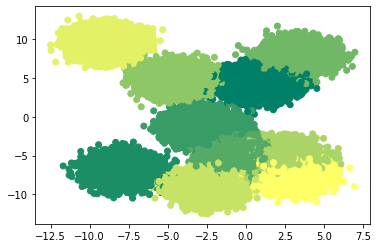

In [6]:
X, y = make_blobs(n_samples=60000, n_features=28*28, centers=10, random_state=0)
y = y.reshape((y.shape[0], 1))

print(X.shape,y.shape)
print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[:,0], X[:, 1], c=y, cmap='summer')
plt.show()

# Defining FFNN components

In [7]:
def weights_matrice(m,n):
    matrix=np.random.standard_normal((m,n))
    sqrt=math.sqrt(n)
    scalaire=1/sqrt
    matrix=scalaire*matrix
    return matrix
    
    

In [8]:
def sigmoide(z_i):
    return 1/(1+np.exp(-z_i))

# normaliser poids
def softmax(array):
    return (np.exp(array - array.max()))/np.sum(np.exp(array - array.max()))


def dsigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)


# import numpy as np
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))
# # derivative of sigmoid
# # sigmoid(y) * (1.0 - sigmoid(y))
# # the way we use this y is already sigmoided
# def dsigmoid(x):
#     return np.multiply(sigmoide(x),(1.0 - sigmoide(x)))

# pour envoyer d'un seul cooup tout un set d'images ou toutes les images d'un coup
def forward_pass_all_1(batches_of_data,w1_all__,w2_all__,w3_all__):
    #Première couche
    z1_all_images= np.tensordot(batches_of_data, w1_all__,axes=((2),(0))) #(1,60000, 784) * 784x128 -> 12000x5x128
    a1_all_images= sigmoide(z1_all_images) #shape de z1 : 1,60000,128 -> shape de a1_all_images:  1,60000,128 
    # On fait paser les sorties à la seconde couche de neurones
    z2_all_images=np.tensordot(a1_all_images,w2_all__, axes=((2),(0)))  #1,60000,128  * 128x64 -> 1,60000,64
    a2_all_images=sigmoide(z2_all_images) # 1,60000,128
    # On fait paser les sorties à la troisième couche de neurones
    z3_all_images=np.tensordot(a2_all_images,w3_all__, axes=((2),(0))) # -> z3 : 1,60000,10
    a3_all_images=softmax(z3_all_images) # -> a3_all : 1,60000,10
    return (batches_of_data,z1_all_images,z2_all_images,z3_all_images,a1_all_images,a2_all_images,a3_all_images)

def forward_pass_all_2(matrix,w1_all,w2_all,w3_all):
    #shape de matrix : (60000,784)
    # 1. aggrégation
    z1_all_images= matrix.dot(w1_all) #  60000x786 dot  786x128 -> 60000x128
    # 2. activation
    a1_all_images= sigmoide(z1_all_images) #shape de z1 : 60000x128
    # On fait paser les sorties à la seconde couche de neurones
    z2_all_images=a1_all_images.dot(w2_all) #60000x128 * 128x64 -> 60000x64
    a2_all_images=sigmoide(z2_all_images) # 60000x64
    z3_all_images=a2_all_images.dot(w3_all) # -> z3 : 60000x10
    a3_all_images=softmax(z3_all_images) # -> a3 : 60000x10
    return (matrix,z1_all_images,z2_all_images,z3_all_images,a1_all_images,a2_all_images,a3_all_images)


# pour toutes les images d'un seul coup
def backpropagation_all_1(batches_, z_1_all, z_2_all, z3, a_3_all, a_2_all, a_1_all, label, w1_, w2_, w3_):
    e_3 = a_3_all - label
    e_2 = np.multiply(e_3.dot(w3_.T), dsigmoid(z_2_all))  # shape e2 : (1,60000,64)
    e_1 = np.multiply(e_2.dot(w2_.T), dsigmoid(z_1_all))  # shape e1 : (1,60000,128)
    delta_w3_all = np.tensordot(a_2_all.T, e_3, axes=([2,1], [0,1]))  # shape :(128,60000,1)*(1,60000,10) -> (128,10)
    delta_w2_all = np.tensordot(a_1_all.T, e_2,  axes=([2,1], [0,1]))  # shape :(128,64)
    delta_w1_all = np.tensordot(batches_.T, e_1,  axes=([2,1], [0,1]))  # shape :(784,128)
    return (delta_w3_all, delta_w2_all, delta_w1_all)


def backpropagation_all_2(matrix_, z_1_all, z_2_all, z3, a_3_all, a_2_all, a_1_all, label, w1_, w2_, w3_):
    e_3 = a_3_all - label  # e3 : (60000,10)
    e_2 = np.multiply(e_3.dot(w3_.T), dsigmoid(z_2_all))  # shape e2 : (60000, 64)
    e_1 = np.multiply(e_2.dot(w2_.T), dsigmoid(z_1_all))  # shape e1 : (60000, 128)

    delta_w3_all = a_2_all.T.dot(e_3)  # shape :(64,10)
    delta_w2_all = a_1_all.T.dot(e_2)  # shape : (128, 64)
    delta_w1_all = matrix_.T.dot(e_1)  # shape: (784, 128)

    return (delta_w3_all, delta_w2_all, delta_w1_all)
    
    
    

def update(dw1, dw2,dw3,w_1__,w_2__,w_3__, lambd):
    w_1_new = w_1__ - (lambd*dw1)
    w_2_new = w_2__ - (lambd*dw2)
    w_3_new = w_3__ - (lambd*dw3)
    
   

    return (w_1_new,w_2_new,w_3_new)



In [9]:
def compute_error(A,y):
    epsilon = 1e-15
    return 1 / len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

def compute_error_all_1(test_data_x_test,test_data_label_test,updated_w1,updated_w2,updated_w3):
    new_test_data,new_z1__,new_z2__,new_z3__,new_a1__,new_a2__,new_a3__=forward_pass_all_1(test_data_x_test,updated_w1,updated_w2,updated_w3)
    indice_max_y=np.argmax(test_data_label_test,axis=2)
    indice_max_a=np.argmax(new_a3__,axis=2)
    error_per_batch=1-np.mean(indice_max_a==indice_max_y)
    return error_per_batch

def compute_error_all_2(test_data_x_test,test_data_label_test,updated_w1,updated_w2,updated_w3):
    new_test_data,new_z1__,new_z2__,new_z3__,new_a1__,new_a2__,new_a3__=forward_pass_all_2(test_data_x_test,updated_w1,updated_w2,updated_w3)
    indice_max_y=np.argmax(test_data_label_test,axis=1)
    indice_max_a=np.argmax(new_a3__,axis=1)
    error_per_batch=1-np.mean(indice_max_a==indice_max_y)
    return error_per_batch






In [15]:
def intialisation(m,n,p,c):
    poids1=weights_matrice(m,n) # W1 contient autant de paramètres que ce qu'il y de variables dans X_train
    poids2=weights_matrice(n,p)
    poids3=weights_matrice(p,c)
    return (poids1,poids2,poids3)

In [10]:



def train_all_1(test_data_x,test_data_y,train_data_x, train_label_array, learning_rate = 100, epochs = 30):
    train_data_x=preprocessing(train_data_x)
    train_label_array=preprocessing_label(train_label_array)
    test_data_x=preprocessing(test_data_x)
    test_data_y=preprocessing_label(test_data_y)
    train_data_x=np.expand_dims(train_data_x, axis=0)
    train_label_array=np.expand_dims(train_label_array, axis=0)
    test_data_x=np.expand_dims(test_data_x, axis=0)
    test_data_y=np.expand_dims(test_data_y, axis=0)    
    w1,w2,w3=intialisation(784,128,64,10)
    for i in range(0,epochs):
        new_batch,z1__batch,z2__batch,z3__batch,a1__batch,a2__batch,a3__batch=forward_pass_all_1(train_data_x,w1,w2,w3)
        delta_w3__,delta_w2__,delta_w1__=backpropagation_all_1(new_batch,z1__batch,z2__batch,z3__batch,a3__batch,a2__batch,a1__batch,train_label_array,w1,w2,w3)
        w1_updated__,w2_updated__,w3_updated__=update(delta_w1__, delta_w2__,delta_w3__,w1,w2,w3, learning_rate)
        w1,w2,w3=w1_updated__,w2_updated__,w3_updated__
        mean_total_errors=compute_error_all_1(test_data_x,test_data_y,w1_updated__,w2_updated__,w3_updated__)
        print('epoch: ' + str(i) + ' error rate: ' + str(mean_total_errors)+'\n')
    return mean_total_errors


def train_all_2(test_data_x,test_data_y,train_data_x, train_label_array, learning_rate = 100, epochs = 30):
    train_data_x=preprocessing(train_data_x)
    train_label_array=preprocessing_label(train_label_array)
    test_data_x=preprocessing(test_data_x)
    test_data_y=preprocessing_label(test_data_y)
    w1,w2,w3=intialisation(784,128,64,10)
    for i in range(0,epochs):
        new_batch,z1__batch,z2__batch,z3__batch,a1__batch,a2__batch,a3__batch=forward_pass_all_1(train_data_x,w1,w2,w3)
        delta_w3__,delta_w2__,delta_w1__=backpropagation_all_1(new_batch,z1__batch,z2__batch,z3__batch,a3__batch,a2__batch,a1__batch,train_label_array,w1,w2,w3)
        w1_updated__,w2_updated__,w3_updated__=update(delta_w1__, delta_w2__,delta_w3__,w1,w2,w3, learning_rate)
        w1,w2,w3=w1_updated__,w2_updated__,w3_updated__
        mean_total_errors=compute_error_all_1(test_data_x,test_data_y,w1_updated__,w2_updated__,w3_updated__)
        print('epoch: ' + str(i) + ' error rate: ' + str(mean_total_errors)+'\n')
    return mean_total_errors





        
    

In [11]:
x_train,y_train,x_test,y_test=read_idx(file3),read_idx(file4),read_idx(file1),read_idx(file2)
print(x_test.shape)
print(y_test.shape)



(10000, 28, 28)
(10000,)


In [12]:
train_all_1(x_train,y_train,x_train, y_train)

KeyboardInterrupt: 